In [1]:
import numpy as np
import os
import sys
from IPython.display import display, Image
import pickle
from scipy import ndimage, misc
import cv2
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Getting steering data for each frame

In [51]:
import pandas as pd
ts_center = pd.read_csv('data/timestamps-center.csv', names=['timestamp'])
ts_left = pd.read_csv('data/timestamps-left.csv', names=['timestamp'])
ts_right = pd.read_csv('data/timestamps-right.csv', names=['timestamp'])
steering = pd.read_csv('data/steering.csv')

In [192]:
num_images = 15212
print('Checking if we have 1 timestamp per image')
print(ts_center.shape[0] == num_images)
print(ts_left.shape[0] == num_images)
print(ts_right.shape[0] == num_images)

ts_center['steering_wheel_angle'] = np.interp(ts_center.timestamp, steering.timestamp, steering.steering_wheel_angle)
ts_center['steering_wheel_torque'] = np.interp(ts_center.timestamp, steering.timestamp, steering.steering_wheel_torque)
ts_center['speed'] = np.interp(ts_center.timestamp, steering.timestamp, steering.speed)

ts_left['steering_wheel_angle'] = np.interp(ts_left.timestamp, steering.timestamp, steering.steering_wheel_angle)
ts_left['steering_wheel_torque'] = np.interp(ts_left.timestamp, steering.timestamp, steering.steering_wheel_torque)
ts_left['speed'] = np.interp(ts_left.timestamp, steering.timestamp, steering.speed)

ts_right['steering_wheel_angle'] = np.interp(ts_right.timestamp, steering.timestamp, steering.steering_wheel_angle)
ts_right['steering_wheel_torque'] = np.interp(ts_right.timestamp, steering.timestamp, steering.steering_wheel_torque)
ts_right['speed'] = np.interp(ts_right.timestamp, steering.timestamp, steering.speed)

ts_center.to_csv('data/center_steering.csv', index=False)
ts_left.to_csv('data/left_steering.csv', index=False)
ts_right.to_csv('data/right_steering.csv', index=False)

Checking if we have 1 timestamp per image
True
True
True


## Exploring the steering data

In [53]:
ts_center.head()

,timestamp,steering_wheel_angle,steering_wheel_torque,speed
0,1475186965612234877,-0.046494,-0.704896,14.607331
1,1475186965661760065,-0.046939,-0.549240,14.616667
2,1475186965711940805,-0.043633,-0.274448,14.613889
3,1475186965761735010,-0.040143,-0.018747,14.625833
4,1475186965811919396,-0.036652,-0.462231,14.616607


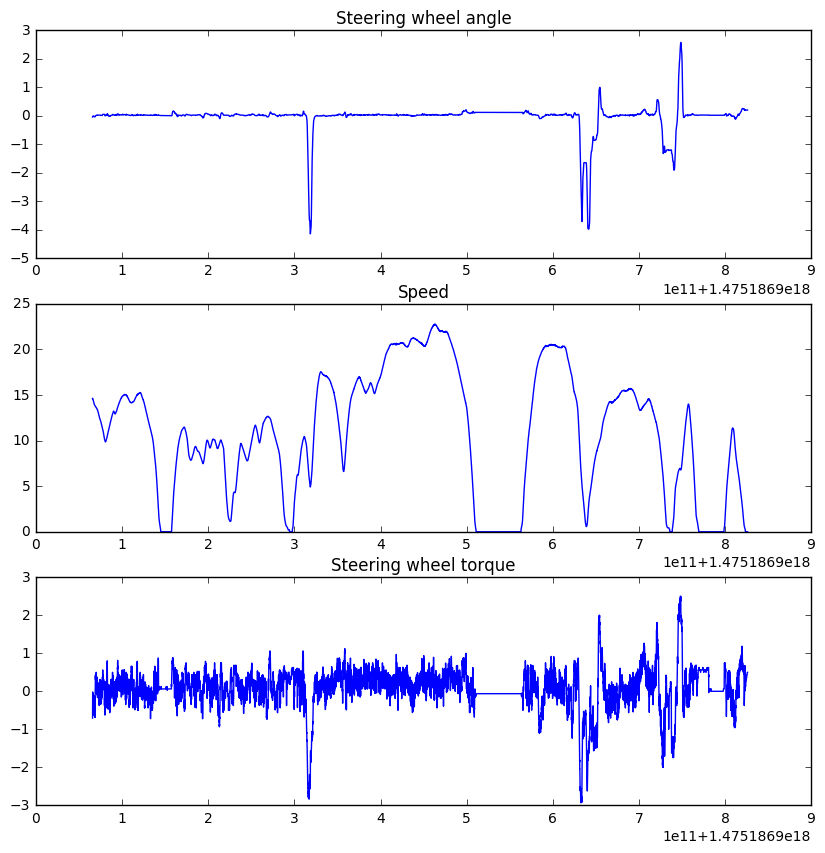

In [54]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(311, title='Steering wheel angle')
plt.plot(ts_center.timestamp, ts_center.steering_wheel_angle)
fig.add_subplot(312, title='Speed')
plt.plot(ts_center.timestamp, ts_center.speed)
fig.add_subplot(313, title='Steering wheel torque')
plt.plot(ts_center.timestamp, ts_center.steering_wheel_torque)

### Finding "stopped" intervals

Let's consider the vehicle is stopped when we have very low speed.

(1.4751869e+18, 1.4751878e+18, 0.0, 1.2)

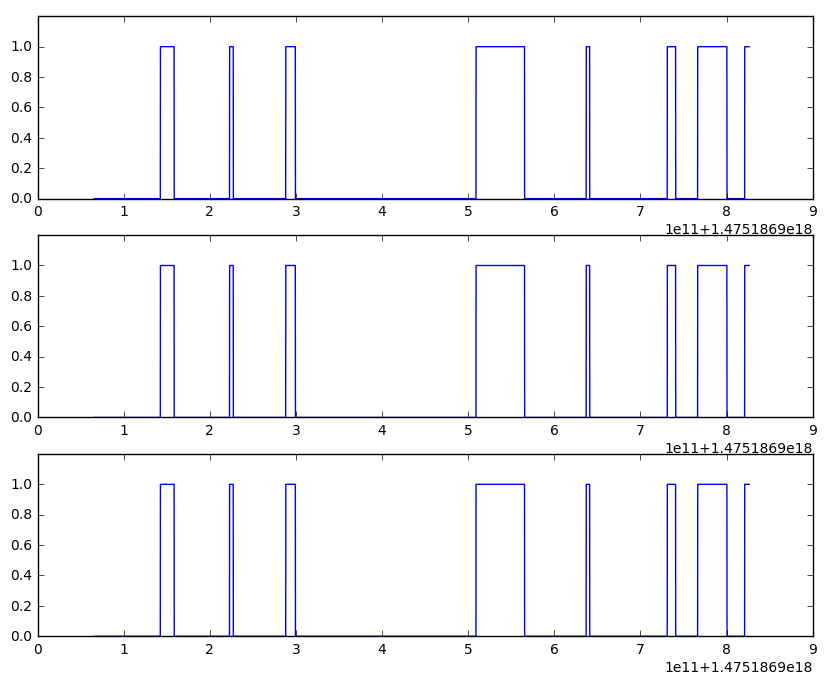

In [194]:
def get_stopped(data):
    return data.speed < .5 * (speed_mean - speed_std) # & (abs(ts_center.steering_wheel_torque) < .1)

stopped_center = get_stopped(ts_center)
stopped_left = get_stopped(ts_left)
stopped_right = get_stopped(ts_right)

fig = plt.figure(figsize=(10, 8))

fig.add_subplot(311)
plt.plot(ts_center.timestamp, stopped_center)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

fig.add_subplot(312)
plt.plot(ts_left.timestamp, stopped_left)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

fig.add_subplot(313)
plt.plot(ts_right.timestamp, stopped_right)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

### Finding sharp turns

Sharp turns are characterized by high_angles & (high_torque | low_speed).

In [98]:
# some statistics
steering_wheel_angle_mean = steering.steering_wheel_angle.mean()
steering_wheel_angle_std = steering.steering_wheel_angle.std()
steering_wheel_torque_mean = steering.steering_wheel_torque.mean()
steering_wheel_torque_std = steering.steering_wheel_torque.std()
speed_mean = steering.speed.mean()
speed_std = steering.speed.std()
print('Steering angle mean: {0:.3f} +/- {1:.3f}'.format(steering_wheel_angle_mean, steering_wheel_angle_std))
print('Steering torque mean: {0:.3f} +/- {1:.3f}'.format(steering_wheel_torque_mean, steering_wheel_torque_std))
print('Speed mean: {0:.3f} +/- {1:.3f}'.format(speed_mean, speed_std))

Steering angle mean: -0.051 +/- 0.520
Steering torque mean: 0.076 +/- 0.532
Speed mean: 10.758 +/- 6.819


(0.0, 16000.0, 0.0, 1.2)

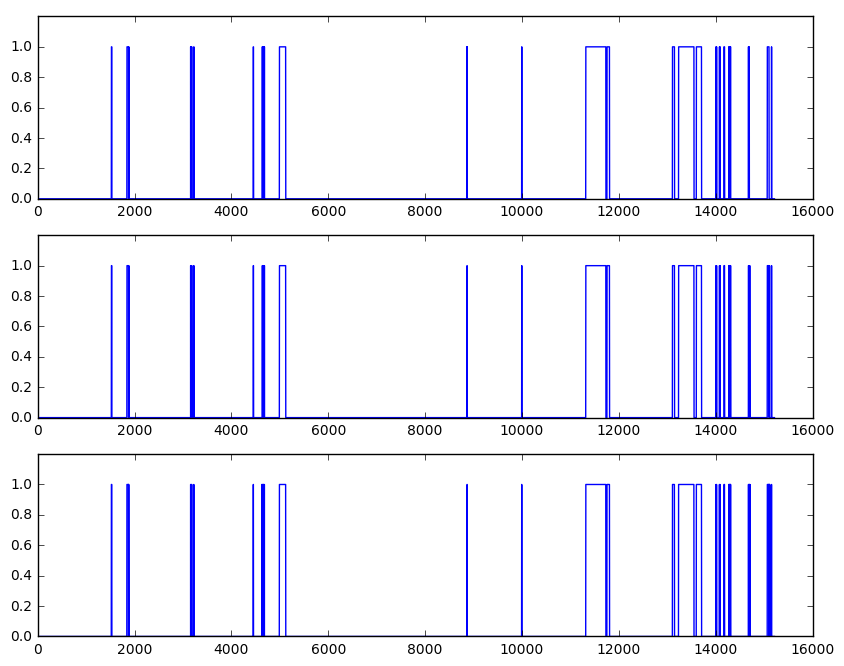

In [201]:
def get_sharp_turns(data):
    high_angles = abs(data.steering_wheel_angle - steering_wheel_angle_mean) > 1. * steering_wheel_angle_std
    high_torque = abs(data.steering_wheel_torque - steering_wheel_torque_mean) > 1. * steering_wheel_torque_std
    low_speed = data.speed < 1. * (speed_mean - speed_std)

    return high_angles | (high_torque & low_speed)

sharp_center = get_sharp_turns(ts_center)
sharp_left = get_sharp_turns(ts_left)
sharp_right = get_sharp_turns(ts_right)

fig = plt.figure(figsize=(10, 8))
fig.add_subplot(311)
plt.plot(ts_center.index, sharp_center)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

fig.add_subplot(312)
plt.plot(ts_left.index, sharp_left)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

fig.add_subplot(313)
plt.plot(ts_right.index, sharp_right)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

### Frames to exclude

Since we are only interested in following lanes, we exclude sharp turns and stopped frames.

(0.0, 16000.0, 0.0, 1.2)

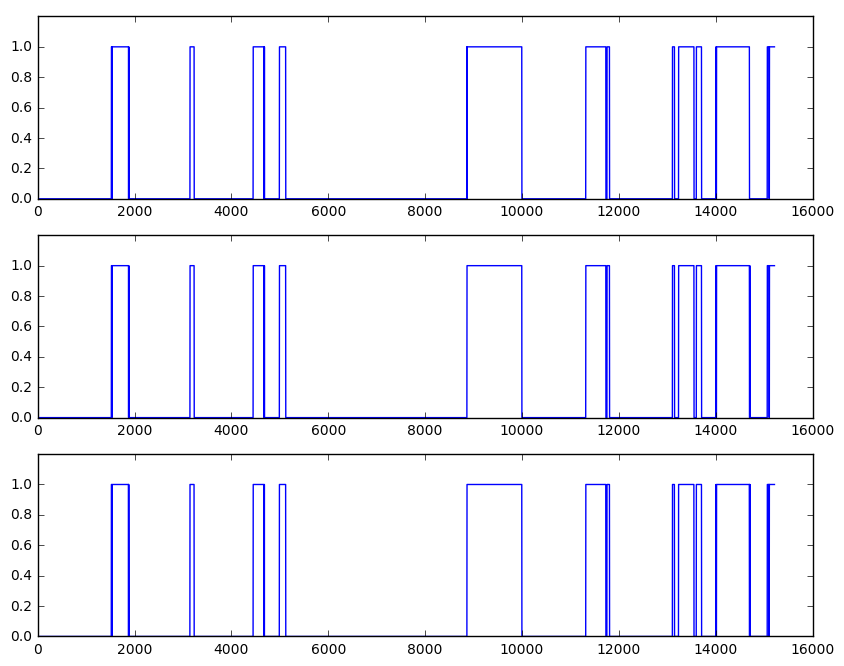

In [202]:
exclude_center = stopped_center | sharp_center
exclude_right = stopped_right | sharp_right
exclude_left = stopped_left | sharp_left

fig = plt.figure(figsize=(10, 8))
fig.add_subplot(311)
plt.plot(ts_center.index, exclude_center)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

fig.add_subplot(312)
plt.plot(ts_left.index, exclude_left)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

fig.add_subplot(313)
plt.plot(ts_right.index, exclude_right)
ax = plt.axis()
plt.axis((ax[0], ax[1], ax[2], 1.2))

(15212, 4) (11525, 4)


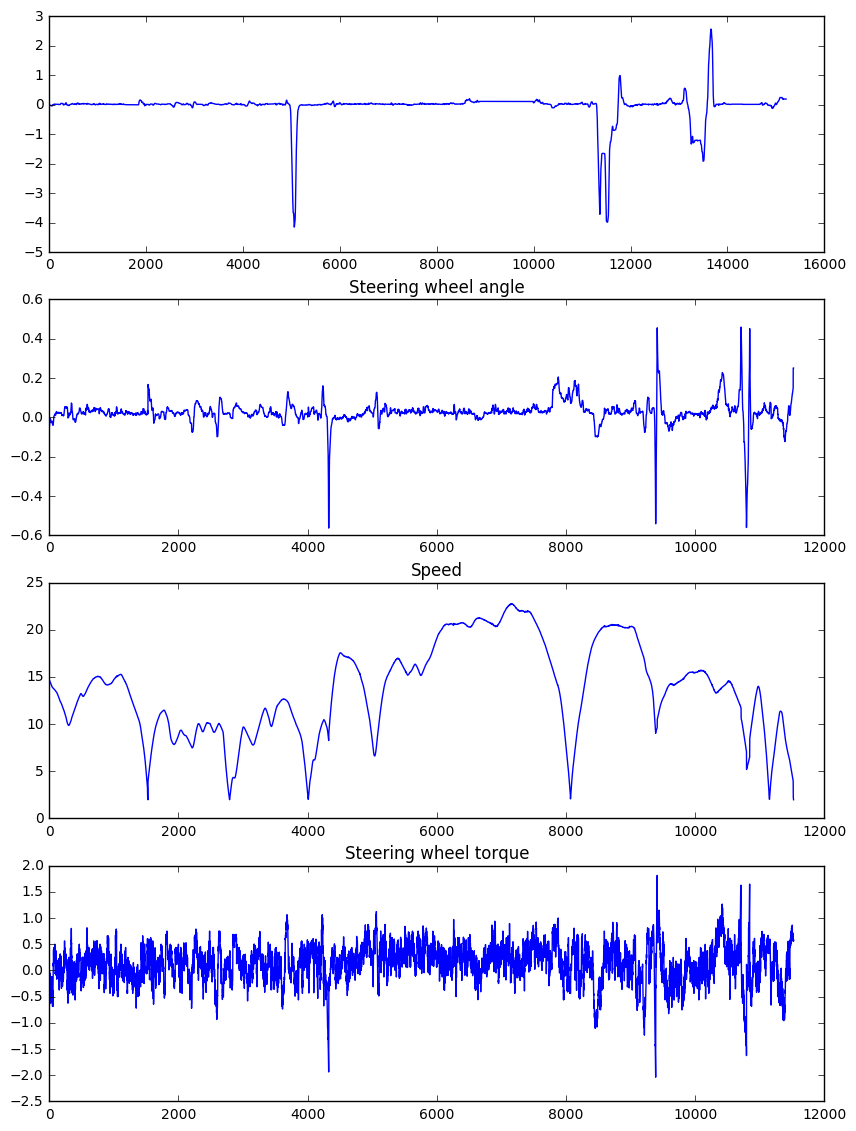

In [215]:
fig = plt.figure(figsize=(10, 14))
print(ts_center.shape, ts_center[include_center].shape)

filtered_center = ts_center[~exclude_center]
filtered_left = ts_left[~exclude_left]
filtered_right = ts_right[~exclude_right]
#filtered_center.reset_index(inplace=True)

fig.add_subplot(411)
plt.plot(ts_center.index, ts_center.steering_wheel_angle)
fig.add_subplot(412, title='Steering wheel angle')
plt.plot(range(filtered_center.shape[0]), filtered_center.steering_wheel_angle)
fig.add_subplot(413, title='Speed')
plt.plot(range(filtered_center.shape[0]), filtered_center.speed)
fig.add_subplot(414, title='Steering wheel torque')
plt.plot(range(filtered_center.shape[0]), filtered_center.steering_wheel_torque)

# Image processing


## Show random images from cameras

Assuming images are already extracted from rosbag file.

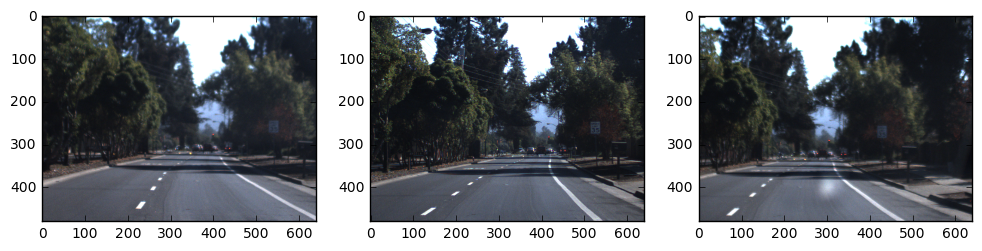

In [212]:
image_folders = ['data/left_camera', 'data/center_camera', 'data/right_camera']

fig = plt.figure(figsize=(12, 10))
choice = np.random.choice(os.listdir(image_folders[i]))

for i in range(len(image_folders)):    
    img = cv2.imread(os.path.join(image_folders[i], choice))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img)
    #display(Image(os.path.join(image_folders[i], np.random.choice(os.listdir(image_folders[i])))))

## Serialize resized images

In [390]:
import numpy as np
import tensorflow as tf
import augmentation as aug
from tqdm import tnrange, tqdm_notebook

def create_example(image, data, colorspace):
    
    feature = {}
    
    feature['steering_angle'] = tf.train.Feature(
            float_list=tf.train.FloatList(value=[data.get('steering_wheel_angle')]))
    
    feature['timestamp'] = tf.train.Feature(
            float_list=tf.train.FloatList(value=[data.get('timestamp')]))
        
    if data.get('steering_wheel_torque'):
        feature['steering_torque'] = tf.train.Feature(
                float_list=tf.train.FloatList(value=[data.get('steering_wheel_torque')]))
        
    if data.get('speed'):
        feature['speed'] = tf.train.Feature(
                float_list=tf.train.FloatList(value=[data.get('speed')]))
        
    feature['image/height'] = tf.train.Feature(
            int64_list=tf.train.Int64List(value=[image.shape[0]]))
    
    feature['image/width'] = tf.train.Feature(
            int64_list=tf.train.Int64List(value=[image.shape[1]]))
    
    feature['image/channels'] = tf.train.Feature(
            int64_list=tf.train.Int64List(value=[image.shape[2]]))
    
    feature['image/colorspace'] = tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[colorspace]))
    
    feature['image'] = tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[image.tostring()]))
    
    # construct the Example proto object
    example = tf.train.Example(
        # Example contains a Features proto object
        features=tf.train.Features(
          # Features contains a map of string to Feature proto objects
          feature=feature
    ))
    
    return example

def create_transformed_example(image, data, colorspace, rotation=None, shift=None, initial_shift=0, 
                               width=None, height=None):
    
    transformed, steering_wheel_angle, r, s = aug.steer_back_distortion(image, 
                                                                        data.steering_wheel_angle, 
                                                                        data.speed,
                                                                        rotation=rotation, shift=shift,
                                                                        initial_shift=initial_shift
                                                                       )
    transformed_data = {
        'steering_wheel_angle': steering_wheel_angle,
        'speed': data.speed,
        'timestamp': data.timestamp
    }

    if width and height:
        transformed = cv2.resize(transformed,(width, height))

    return create_example(transformed, transformed_data, image_colorspace)


image_width_small = 200
image_height_small = 90
image_channels = 3
image_colorspace = b'YUV'

filtered_idx = [filtered_left.index, filtered_center.index, filtered_right.index]
steering_files = ['data/left_steering.csv', 'data/center_steering.csv', 'data/right_steering.csv']
initial_shifts = [-.5, 0, .5]
augmentation_factor = 5
train_ratio = 0.6
images_per_file = 2000

for i in tnrange(len(image_folders)):
    
    folder = image_folders[i]
    
    idxs = np.array(filtered_idx[i])
    #np.random.shuffle(idxs)
    
    image_files = os.listdir(folder)
    steering = pd.read_csv(steering_files[i])
    
    # iterate over each example
    # wrap with tqdm for a progress bar
    file_count = math.ceil(len(idxs) / images_per_file)
    
    for j in tnrange(file_count):
        
        filename = '{}@{}x{}_{}.tfrecords'.format(folder, image_height_small, image_width_small, j)
        writer = tf.python_io.TFRecordWriter(filename)
        
        images_in_file = images_per_file
        
        if (len(idxs) - j * images_per_file) < images_per_file:
            images_in_file = len(idxs) % images_per_file
        
        for k in tnrange(images_in_file):
        
            example_idx = idxs[j * images_per_file + k]
            
            try:
                img = cv2.imread(os.path.join(folder, image_files[example_idx]))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            except:
                print('Could not read:', os.path.join(folder, image_files[example_idx]), '- it\'s ok, skipping.')
                continue
            
            data = steering.iloc[example_idx]

            example = create_transformed_example(img, data, image_colorspace, initial_shift=initial_shifts[i],
                                                 rotation=0, shift=0,
                                                 width=image_width_small, height=image_height_small)

            # use the proto object to serialize the example to a string
            serialized = example.SerializeToString()

            # write the serialized object to disk
            writer.write(serialized)
            
            for k in range(augmentation_factor-1):
                
                example = create_transformed_example(img, data, image_colorspace, initial_shift=initial_shifts[i], 
                               width=image_width_small, height=image_height_small)
                serialized = example.SerializeToString()

                writer.write(serialized)
                
        writer.close()
    

Could not read: data/right_camera/.DS_Store - it's ok, skipping.



## Check images

0.08074460178613663
0.08746244758367538
0.06318225711584091
0.11378806829452515
0.07198955118656158


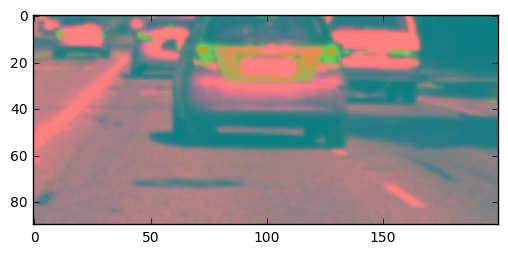

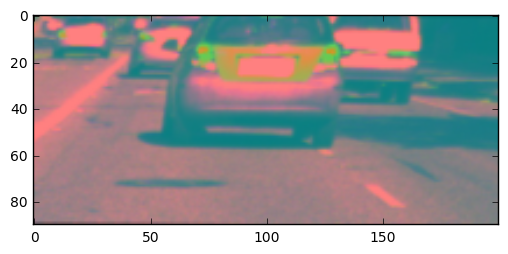

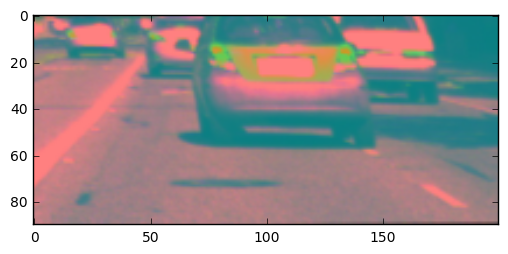

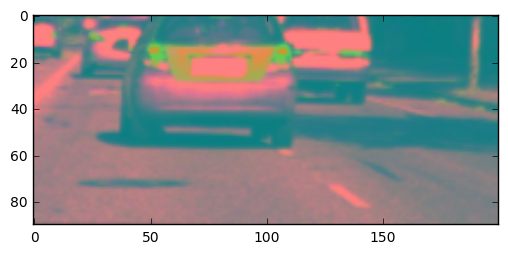

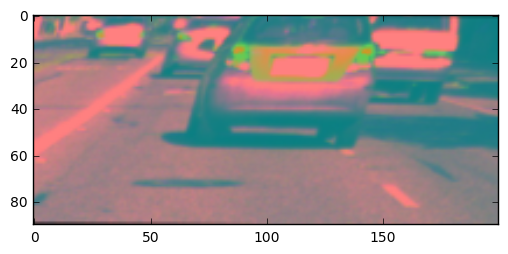

In [388]:
i = 0
for serialized_example in tf.python_io.tf_record_iterator(filename):
    
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    
    # traverse the Example format to get data
    height = example.features.feature['image/height'].int64_list.value[0]
    width = example.features.feature['image/width'].int64_list.value[0]
    channels = example.features.feature['image/channels'].int64_list.value[0]
    image = example.features.feature['image'].bytes_list.value[0]
    image = np.fromstring(image, np.uint8)
    image = np.asarray(image)
    image = image.reshape(height, width, channels)
    steering = example.features.feature['steering_angle'].float_list.value[0]
    
    if i < 10:
        fig = plt.figure()
        plt.imshow(image)
        print(steering)
    i = i + 1